In [1]:
from __future__ import division, print_function

# отключим всякие предупреждения Anaconda
import warnings
import os

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import pylab as plt

%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (6, 4)

**Скачиваем нужные csv-файлы с github**

Набор данных взят с сайта: 
https://www.kaggle.com/quantbruce/real-estate-price-prediction

In [2]:
if not os.path.exists('../data'): os.mkdir("../data")

!curl -o ../data/RealEstate.csv https://raw.githubusercontent.com/NoxNokas/HomeWork/main/data/RealEstate.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 21968  1 0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     000 21968    0     0  86830      0 --:--:-- --:--:-- --:--:-- 86830


# Регрессия

In [3]:
# импортируем библиотеки
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.linear_model import LassoCV, RidgeCV # Cross Validation специальная для гребневой регуляризации и Лассо
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import metrics, svm
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
    KFold,
    cross_val_predict,
    cross_val_score,
    train_test_split,
)

## Предобработка и визуализация данных 

In [4]:
df = pd.read_csv("../data/RealEstate.csv")
pd.concat([df.head(), df.tail()])

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1
409,410,2013.000,13.7,4082.01500,0,24.94155,121.50381,15.4
410,411,2012.667,5.6,90.45606,9,24.97433,121.54310,50.0
411,412,2013.250,18.8,390.96960,7,24.97923,121.53986,40.6
412,413,2013.000,8.1,104.81010,5,24.96674,121.54067,52.5
413,414,2013.500,6.5,90.45606,9,24.97433,121.54310,63.9


Описание параметров: Прогноз цен на недвижимость 

parameter | description 
--- | --- 
X1 | Дата транзакции.
X2 | Возраст дома.
X3 | Расстояние до ближайшей станции MRT.
X4 | Общее количество круглосуточных магазинов.
X5 | Широта.
X6 | Долгота.
**Y**  | Цена дома.

**Y** - это выход и, следовательно, зависимая переменная.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   No                                      414 non-null    int64  
 1   X1 transaction date                     414 non-null    float64
 2   X2 house age                            414 non-null    float64
 3   X3 distance to the nearest MRT station  414 non-null    float64
 4   X4 number of convenience stores         414 non-null    int64  
 5   X5 latitude                             414 non-null    float64
 6   X6 longitude                            414 non-null    float64
 7   Y house price of unit area              414 non-null    float64
dtypes: float64(6), int64(2)
memory usage: 26.0 KB


Проверяем корреляцию

In [6]:
df.corr()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
No,1.000000,-0.048658,-0.032808,-0.013573,-0.012699,-0.010110,-0.011059,-0.028587
X1 transaction date,-0.048658,1.000000,0.017549,0.060880,0.009635,0.035058,-0.041082,0.087491
X2 house age,-0.032808,0.017549,1.000000,0.025622,0.049593,0.054420,-0.048520,-0.210567
X3 distance to the nearest MRT station,-0.013573,0.060880,0.025622,1.000000,-0.602519,-0.591067,-0.806317,-0.673613
X4 number of convenience stores,-0.012699,0.009635,0.049593,-0.602519,1.000000,0.444143,0.449099,0.571005
X5 latitude,-0.010110,0.035058,0.054420,-0.591067,0.444143,1.000000,0.412924,0.546307
X6 longitude,-0.011059,-0.041082,-0.048520,-0.806317,0.449099,0.412924,1.000000,0.523287
Y house price of unit area,-0.028587,0.087491,-0.210567,-0.673613,0.571005,0.546307,0.523287,1.000000


Проверка на количество Null в столбцах

In [7]:
df.isnull().sum()

No                                        0
X1 transaction date                       0
X2 house age                              0
X3 distance to the nearest MRT station    0
X4 number of convenience stores           0
X5 latitude                               0
X6 longitude                              0
Y house price of unit area                0
dtype: int64

Удаляем столбцы с номером и датой транзакции

In [8]:
df.drop(["X1 transaction date", "No"], axis=1, inplace= True)

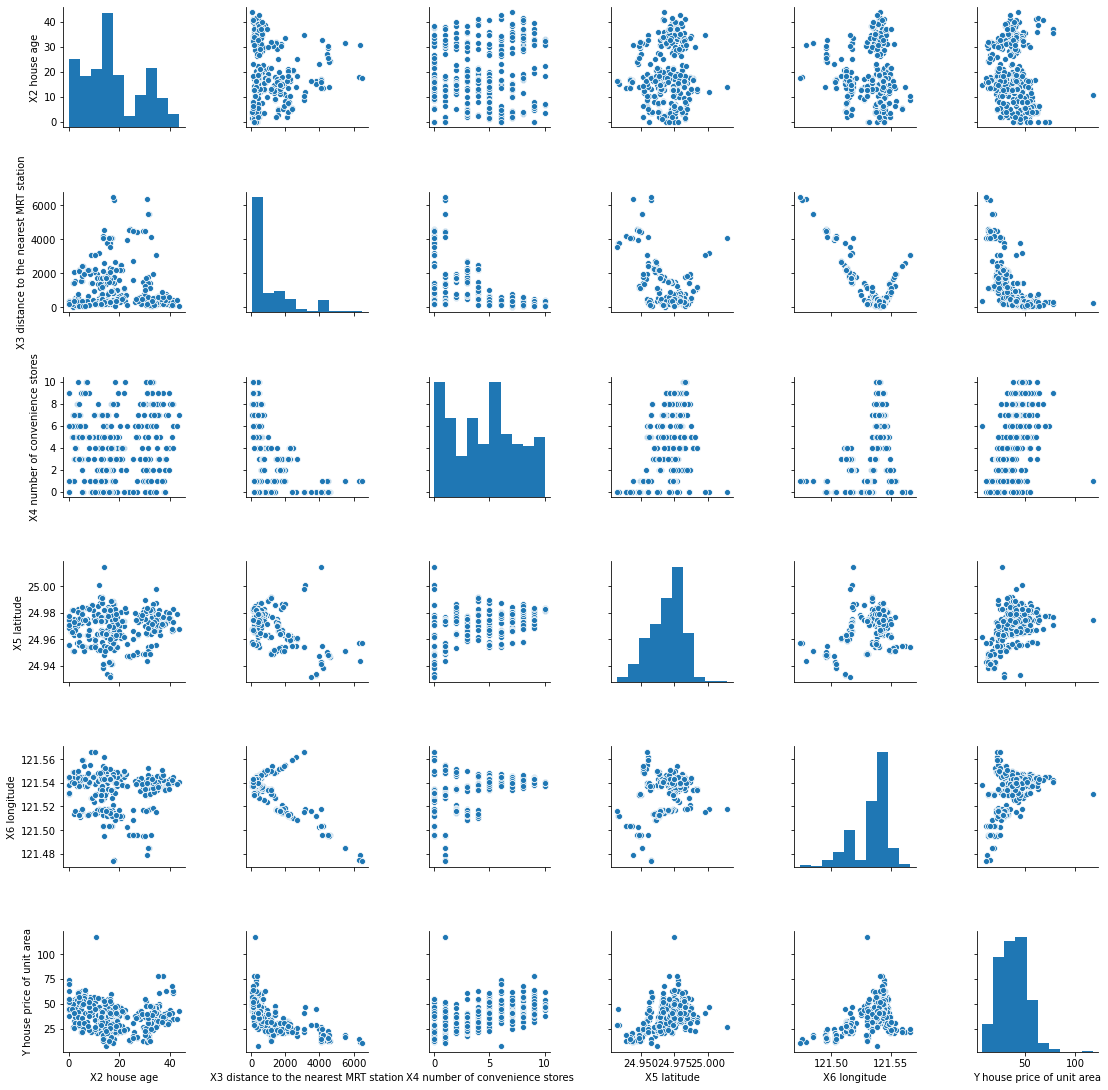

In [9]:
sns.pairplot(df);

визуализируем корреляцию с помощью heatmap 

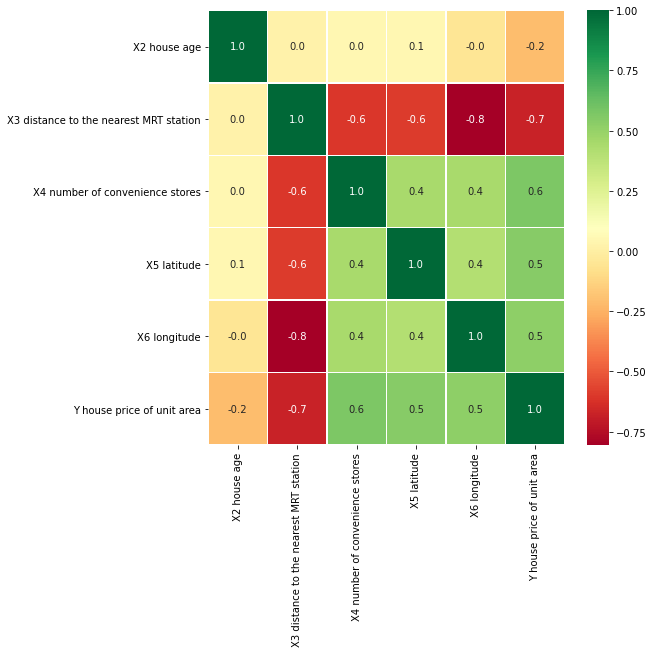

In [10]:
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(df.corr(), annot=True, cmap="RdYlGn", linewidths=.5, fmt= '.1f',ax=ax);

Визуализация результата набора данных обучения

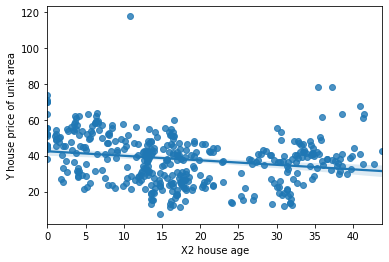

In [11]:
sns.regplot(x="X2 house age", y="Y house price of unit area", data=df);

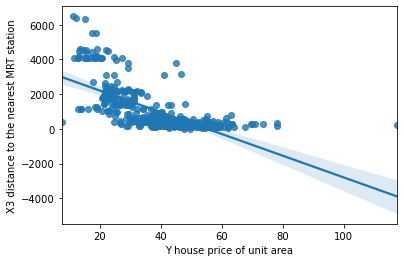

In [12]:
sns.regplot(y="X3 distance to the nearest MRT station", x="Y house price of unit area", data=df);

Делим параметры на зависимые (y) и независимые (X)

In [13]:
X = df.loc[:,'X2 house age' : 'X6 longitude']
y = df.loc[:,'Y house price of unit area']

Разделяем выборку на обучающую и тестовую

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3,random_state = 0)

## Регрессия на основе k-ближайших соседей.

In [15]:
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)

KNeighborsRegressor()

In [16]:
print("MSE=%f" % np.sqrt(metrics.mean_squared_error(y_test, knn_model.predict(X_test))))

MSE=9.206600


## Линейная регрессия

Обучаем модель

In [17]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

Коэффициенты регрессии

In [18]:
pd.DataFrame(reg.coef_, index=X.columns, columns=['coef']).sort_values(by=['coef'], ascending= False)

,coef
X5 latitude,245.047983
X4 number of convenience stores,1.048201
X3 distance to the nearest MRT station,-0.004346
X2 house age,-0.280568
X6 longitude,-6.053154


In [19]:
print("MSE=%f" % np.sqrt(metrics.mean_squared_error(y_test, reg.predict(X_test))))

MSE=8.579388


График прогнозов реальной цены и предсказанной

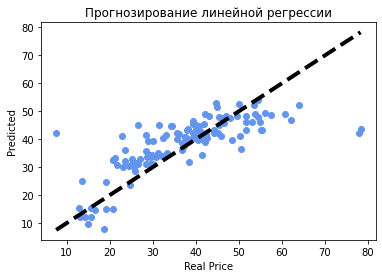

In [20]:
plt.scatter(y_test, reg.predict(X_test), color='cornflowerblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Real Price')
plt.ylabel('Predicted')
plt.title('Прогнозирование линейной регрессии');

## Линейная регрессия с Lasso регуляризотором

In [21]:
lasso_model = Lasso()
lasso_model.fit(X_train, y_train);

Регрессия Лассо не только помогает уменьшить переобучение, но и помогает нам в выборе параметров.

Коэффициенты регрессии:

In [22]:
pd.DataFrame(lasso_model.coef_, index=X.columns, columns=['coef']).sort_values(by=['coef'], ascending= False)

,coef
X4 number of convenience stores,0.963836
X5 latitude,0.000000
X6 longitude,-0.000000
X3 distance to the nearest MRT station,-0.005863
X2 house age,-0.255173


In [23]:
print("MSE=%f" % np.sqrt(metrics.mean_squared_error(y_test, lasso_model.predict(X_test))))

MSE=8.863635


## Линейная регрессия с Ridge регуляризотором

In [24]:
ridge_model = Ridge()
ridge_model.fit(X_train, y_train);

Гребневая регрессия уменьшает коэффициенты и помогает уменьшить сложность модели и мультиколлинеарность.

Коэффициенты регрессии

In [25]:
pd.DataFrame(ridge_model.coef_, index=X.columns, columns=['coef']).sort_values(by=['coef'], ascending= False)

,coef
X5 latitude,7.331458
X4 number of convenience stores,1.151977
X3 distance to the nearest MRT station,-0.005554
X2 house age,-0.264494
X6 longitude,-0.621867


In [26]:
print("MSE=%f" % np.sqrt(metrics.mean_squared_error(y_test, ridge_model.predict(X_test))))

MSE=8.784876


## SVR. Регрессия опорных векторов

In [27]:
svr_model = make_pipeline(StandardScaler(), svm.SVR(C=2.5, epsilon=0.2))
svr_model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=2.5, epsilon=0.2))])

In [28]:
print("MSE=%f" % np.sqrt(metrics.mean_squared_error(y_test, svr_model.predict(X_test))))

MSE=8.351585


График прогнозов реальной цены и предсказанной

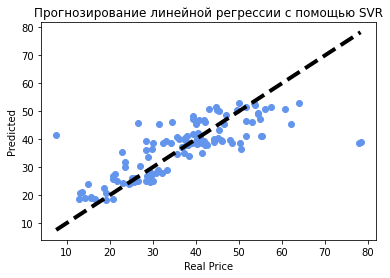

In [29]:
plt.scatter(y_test, svr_model.predict(X_test), color='cornflowerblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Real Price')
plt.ylabel('Predicted')
plt.title('Прогнозирование линейной регрессии с помощью SVR');